# Week 1: Intro to tech

In [47]:
import numpy as np
import uproot
import vector
import awkward
import matplotlib.pyplot as plt
import mplhep as hep

#directory = "/Users/archiebrooks/Documents/Uni/mphys project/"
directory = "c:/Users/matis/OneDrive/Documents/Y4/Project/"

hep.style.use('ATLAS')

## Plotting function

In [48]:
def histogram(data, bins, data_label, axes, density=False, ratio=False, ratio_axes=None, set_range = None):
    if len(data[0]) != 1:
        if set_range is not None:
            global_min, global_max = set_range
        else:
            global_min = min([np.min(d) for d in data])
            global_max = max([np.max(d) for d in data])

        bin_edges = np.linspace(global_min, global_max, bins+1)
        counts = []
        bin_width = bin_edges[1]-bin_edges[0]
        for i in range(len(data)):
            if type(data[i])!= 'numpy.ndarray':
                data[i] = np.array(data[i])
                hist = np.histogram(data[i], bins=bin_edges, density=density)[0]
            counts.append(hist.astype(float))
    else:
        counts, bin_edges = int(np.histogram(data, bins=bins, density=density))
    hep.histplot(counts, bin_edges, ax=axes, label=data_label, histtype='step')
    bin_width = bin_edges[1]-bin_edges[0]
    axes.set_ylabel(f'Events /{bin_width:.2f} GeV')
    axes.legend()

    if ratio:
        reference_counts = counts[0]
        for i in range(1, len(counts)):
            ratio_values = np.divide(counts[i], reference_counts, out=np.zeros_like(counts[i]), where=reference_counts != 0)
            hep.histplot(ratio_values, bin_edges, ax=ratio_axes, label=f'{data_label[i]}/{data_label[0]}')
        ratio_axes.set_ylabel("Ratio")
        ratio_axes.set_xlabel(axes.get_xlabel())
        ratio_axes.axhline(1, color='black', linestyle='--')  # Reference line at ratio=1
        ratio_axes.legend()
        if ratio_axes.get_ylim()[1]>5:
            ratio_axes.set_ylim(0,5)

    hep.atlas.label(ax=axes)

## Unpacking data
### 1. Extracting 4 top data
Filters the data to remove top $p_T$ below 250

In [49]:
tree4 = uproot.open(directory + 'MPHYS-4Top/4tops_partonic_skimmed_2409.root')['tree']
events = tree4.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'anti_top_pt', 'anti_top_eta', 'anti_top_phi', 'anti_top_e'])

for data in tree4.iterate(['top_pt', 'top_eta', 'top_phi', 'top_e', 'anti_top_pt', 'anti_top_eta', 'anti_top_phi', 'anti_top_e']):

    top_pt = awkward.to_numpy(data['top_pt'])
    top_e = awkward.to_numpy(data['top_e'])
    top_eta = awkward.to_numpy(data['top_eta'])
    antitop_eta = awkward.to_numpy(data['anti_top_eta'])


    filtered_top_pt = top_pt[(top_pt[:, 0] >= 250) & (top_pt[:, 1] >= 250)]
    filtered_top_e = top_e[(top_pt[:, 0] >= 250) & (top_pt[:, 1] >= 250)]
    filtered_top_eta = top_eta[(top_pt[:, 0] >= 250) & (top_pt[:, 1] >= 250)]
    filtered_antitop_eta = antitop_eta[(top_pt[:, 0] >= 250) & (top_pt[:, 1] >= 250)]

In [50]:
split_antitop_eta = antitop_eta.reshape(100000,1)
split_filtered_antitop_eta = filtered_antitop_eta.reshape(13634,1)
split_top_eta = top_eta.reshape(100000,1)
split_filtered_top_eta = filtered_top_eta.reshape(13634,1)

### 2. Extracting 3 top data

In [51]:
tree3W = uproot.open(directory + 'MPHYS-4Top/3tops_tttW_partonic_skimmed_2609.root')['tree']
events3W = tree3W.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'anti_top_pt', 'anti_top_eta', 'anti_top_phi', 'anti_top_e'])

events3W['pt'] = awkward.concatenate([events3W['top_pt'],events3W['anti_top_pt']], axis=1)
events3W['eta'] = awkward.concatenate([events3W['top_eta'],events3W['anti_top_eta']], axis=1)
events3W['phi'] = awkward.concatenate([events3W['top_phi'],events3W['anti_top_phi']], axis=1)
events3W['e'] = awkward.concatenate([events3W['top_e'],events3W['anti_top_e']], axis=1)

mask_tttbarW = (awkward.num(events3W['top_pt']) == 2) & (awkward.num(events3W['anti_top_pt']) == 1)
mask_ttbartbarW = (awkward.num(events3W['top_pt']) == 1) & (awkward.num(events3W['anti_top_pt']) == 2)
tttbarW = events3W[mask_tttbarW]
ttbartbarW = events3W[mask_ttbartbarW]

tree3j = uproot.open(directory + 'MPHYS-4Top/3tops_tttj_partonic_skimmed_2609.root')['tree']
events3j = tree3j.arrays(['top_pt', 'top_eta', 'top_phi', 'top_e', 'anti_top_pt', 'anti_top_eta', 'anti_top_phi', 'anti_top_e'])

events3j['pt'] = awkward.concatenate([events3j['top_pt'],events3j['anti_top_pt']], axis=1)
events3j['eta'] = awkward.concatenate([events3j['top_eta'],events3j['anti_top_eta']], axis=1)
events3j['phi'] = awkward.concatenate([events3j['top_phi'],events3j['anti_top_phi']], axis=1)
events3j['e'] = awkward.concatenate([events3j['top_e'],events3j['anti_top_e']], axis=1)

mask_tttbarj = (awkward.num(events3j['top_pt']) == 2) & (awkward.num(events3j['anti_top_pt']) == 1)
mask_ttbartbarj = (awkward.num(events3j['top_pt']) == 1) & (awkward.num(events3j['anti_top_pt']) == 2)
tttbarj = events3j[mask_tttbarj]
ttbartbarj = events3j[mask_ttbartbarj]

## Vectors
### 1. 4 top Masks/Filters
Removes $p_T$ below 50 and $|\eta|$ < 2.4

In [52]:
pt_mask_1 = events['top_pt'][:, 0] > 50
pt_mask_2 = events['top_pt'][:, 1] > 50

eta_mask_1 = (events['top_eta'][:, 0] > -2.4) & (events['top_eta'][:, 0] < 2.4)
eta_mask_2 = (events['top_eta'][:, 1] > -2.4) & (events['top_eta'][:, 1] < 2.4)

anti_pt_mask_1 = events['anti_top_pt'][:, 0] > 50
anti_pt_mask_2 = events['anti_top_pt'][:, 1] > 50

anti_eta_mask_1 = (events['anti_top_eta'][:, 0] > -2.4) & (events['anti_top_eta'][:, 0] < 2.4)
anti_eta_mask_2 = (events['anti_top_eta'][:, 1] > -2.4) & (events['anti_top_eta'][:, 1] < 2.4)

masks = pt_mask_1 & pt_mask_2 & eta_mask_1 & eta_mask_2 & anti_pt_mask_1 & anti_pt_mask_2 & anti_eta_mask_1 & anti_eta_mask_2

### 2. 3 top Masks/Filters
Removes $p_T$ below 50 and $|\eta|$ < 2.4

In [53]:
pt_mask_3tW_1 = events3W['pt'][:,0] > 50
pt_mask_3tW_2 = events3W['pt'][:,1] > 50
pt_mask_3tW_3 = events3W['pt'][:,2] > 50

eta_mask_3tW_1 = (events3W['eta'][:, 0] > -2.4) & (events3W['eta'][:, 0] < 2.4)
eta_mask_3tW_2 = (events3W['eta'][:, 1] > -2.4) & (events3W['eta'][:, 1] < 2.4)
eta_mask_3tW_3 = (events3W['eta'][:, 2] > -2.4) & (events3W['eta'][:, 2] < 2.4)

masks_3tW = pt_mask_3tW_1 & pt_mask_3tW_2 & pt_mask_3tW_3 & eta_mask_3tW_1 & eta_mask_3tW_2 & eta_mask_3tW_3

pt_mask_3tj_1 = events3j['pt'][:,0] > 50
pt_mask_3tj_2 = events3j['pt'][:,1] > 50
pt_mask_3tj_3 = events3j['pt'][:,2] > 50

eta_mask_3tj_1 = (events3j['eta'][:, 0] > -2.4) & (events3j['eta'][:, 0] < 2.4)
eta_mask_3tj_2 = (events3j['eta'][:, 1] > -2.4) & (events3j['eta'][:, 1] < 2.4)
eta_mask_3tj_3 = (events3j['eta'][:, 2] > -2.4) & (events3j['eta'][:, 2] < 2.4)

masks_3tj = pt_mask_3tj_1 & pt_mask_3tj_2 & pt_mask_3tj_3 & eta_mask_3tj_1 & eta_mask_3tj_2 & eta_mask_3tj_3

### 3. 4 top individual awkward vecors

In [54]:
tops = vector.zip({'pt':events['top_pt'],'eta':events['top_eta'],'phi':events['top_phi'], 'mass':172.76})
anti_tops = vector.zip({'pt':events['anti_top_pt'],'eta':events['anti_top_eta'],'phi':events['anti_top_phi'], 'mass':172.76})

filtered_tops= tops[masks]
filtered_anti_tops = anti_tops[masks]

top1 = vector.zip({'pt':events['top_pt'][:,0],'eta':events['top_eta'][:,0],'phi':events['top_phi'][:,0], 'mass':172.76})
top2 = vector.zip({'pt':events['top_pt'][:,1],'eta':events['top_eta'][:,1],'phi':events['top_phi'][:,1], 'mass':172.76})
anti_top1 = vector.zip({'pt':events['anti_top_pt'][:,0],'eta':events['anti_top_eta'][:,0],'phi':events['anti_top_phi'][:,0], 'mass':172.76})
anti_top2 = vector.zip({'pt':events['anti_top_pt'][:,1],'eta':events['anti_top_eta'][:,1],'phi':events['anti_top_phi'][:,1], 'mass':172.76})

all_4tops = awkward.concatenate([awkward.Array([top1]),awkward.Array([top2]),awkward.Array([anti_top1]),awkward.Array([anti_top2])], axis=0)

filtered_top1 = top1[masks]
filtered_top2 = top2[masks]
filtered_anti_top1 = anti_top1[masks]
filtered_anti_top2 = anti_top2[masks]

four_tops = top1+top2+anti_top1+anti_top2
filtered_4_tops = filtered_top1+filtered_top2+filtered_anti_top1+filtered_anti_top2
filtered_4_tops = filtered_4_tops[filtered_4_tops.mass > 1500]

all_filtered_4tops = awkward.concatenate([awkward.Array([filtered_top1]),awkward.Array([filtered_top2]),awkward.Array([filtered_anti_top1]),awkward.Array([filtered_anti_top2])], axis=0)

### 4. 3 top individual awkward vectors

In [55]:
top1_3tW = vector.zip({'pt':events3W['pt'][:,0],'eta':events3W['eta'][:,0],'phi':events3W['phi'][:,0], 'mass':172.76})
top2_3tW = vector.zip({'pt':events3W['pt'][:,1],'eta':events3W['eta'][:,1],'phi':events3W['phi'][:,1], 'mass':172.76})
top3_3tW = vector.zip({'pt':events3W['pt'][:,2],'eta':events3W['eta'][:,2],'phi':events3W['phi'][:,2], 'mass':172.76})

filtered_top1_3tW = top1_3tW[masks_3tW]
filtered_top2_3tW = top2_3tW[masks_3tW]
filtered_top3_3tW = top3_3tW[masks_3tW]

_3tWs = filtered_top1_3tW + filtered_top2_3tW + filtered_top3_3tW
all_filtered_3tW = awkward.concatenate([awkward.Array([filtered_top1_3tW]),awkward.Array([filtered_top2_3tW]), awkward.Array([filtered_top3_3tW])], axis=0)

top1_3tj = vector.zip({'pt':events3j['pt'][:,0],'eta':events3j['eta'][:,0],'phi':events3j['phi'][:,0], 'mass':172.76})
top2_3tj = vector.zip({'pt':events3j['pt'][:,1],'eta':events3j['eta'][:,1],'phi':events3j['phi'][:,1], 'mass':172.76})
top3_3tj = vector.zip({'pt':events3j['pt'][:,2],'eta':events3j['eta'][:,2],'phi':events3j['phi'][:,2], 'mass':172.76})

filtered_top1_3tj = top1_3tj[masks_3tj]
filtered_top2_3tj = top2_3tj[masks_3tj]
filtered_top3_3tj = top3_3tj[masks_3tj]

_3tjs = filtered_top1_3tj + filtered_top2_3tj + filtered_top3_3tj
all_filtered_3tj = awkward.concatenate([awkward.Array([filtered_top1_3tj]),awkward.Array([filtered_top2_3tj]), awkward.Array([filtered_top3_3tj])], axis=0)

## Comparing 3tW and 3tj

### 1. Sorting by $p_T$

In [56]:
transposed_3tW = np.transpose(all_filtered_3tW)
sorted_indices = np.argsort(transposed_3tW.rho)
trans_sorted_3tW = transposed_3tW[sorted_indices]
highest_pt_3tW = vector.zip({'pt':trans_sorted_3tW.rho[:,-1],'eta':trans_sorted_3tW.eta[:,-1],'phi':trans_sorted_3tW.phi[:,-1], 'mass':172.76})
second_highest_pt_3tW = vector.zip({'pt':trans_sorted_3tW.rho[:,-2],'eta':trans_sorted_3tW.eta[:,-2],'phi':trans_sorted_3tW.phi[:,-2], 'mass':172.76})

transposed_3tj = np.transpose(all_filtered_3tj)
sorted_indices = np.argsort(transposed_3tj.rho)
trans_sorted_3tj = transposed_3tj[sorted_indices]
highest_pt_3tj = vector.zip({'pt':trans_sorted_3tj.rho[:,-1],'eta':trans_sorted_3tj.eta[:,-1],'phi':trans_sorted_3tj.phi[:,-1], 'mass':172.76})
second_highest_pt_3tj = vector.zip({'pt':trans_sorted_3tj.rho[:,-2],'eta':trans_sorted_3tj.eta[:,-2],'phi':trans_sorted_3tj.phi[:,-2], 'mass':172.76})

### 2. Sorting by $\eta$ 

In [57]:
sorted_indices = np.argsort(transposed_3tW.eta)
trans_sorted_3tW = transposed_3tW[sorted_indices]
lowest_eta_3tW = vector.zip({'pt':trans_sorted_3tW.rho[:,0],'eta':trans_sorted_3tW.eta[:,0],'phi':trans_sorted_3tW.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(transposed_3tj.eta)
trans_sorted_3tj = transposed_3tj[sorted_indices]
lowest_eta_3tj = vector.zip({'pt':trans_sorted_3tj.rho[:,0],'eta':trans_sorted_3tj.eta[:,0],'phi':trans_sorted_3tj.phi[:,0], 'mass':172.76})

### 3. Sorting by $\phi$

In [58]:
sorted_indices = np.argsort(transposed_3tW.phi)
trans_sorted_3tW = transposed_3tW[sorted_indices]
lowest_phi_3tW = vector.zip({'pt':trans_sorted_3tW.rho[:,-2],'eta':trans_sorted_3tW.eta[:,-2],'phi':trans_sorted_3tW.phi[:,-2], 'mass':172.76})

sorted_indices = np.argsort(transposed_3tj.phi)
trans_sorted_3tj = transposed_3tj[sorted_indices]
lowest_phi_3tj = vector.zip({'pt':trans_sorted_3tj.rho[:,-2],'eta':trans_sorted_3tj.eta[:,-2],'phi':trans_sorted_3tj.phi[:,-2], 'mass':172.76})

### 4. Sorting by energy 

In [59]:
sorted_indices = np.argsort(np.sqrt((transposed_3tW.rho**2)*(np.cosh(transposed_3tW.eta)**2) + transposed_3tW.tau**2))
trans_sorted_3tW = transposed_3tW[sorted_indices]
highest_E_3tW = vector.zip({'pt':trans_sorted_3tW.rho[:,-1],'eta':trans_sorted_3tW.eta[:,-1],'phi':trans_sorted_3tW.phi[:,-1], 'mass':172.76})
second_highest_E_3tW = vector.zip({'pt':trans_sorted_3tW.rho[:,0],'eta':trans_sorted_3tW.eta[:,0],'phi':trans_sorted_3tW.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.sqrt((transposed_3tj.rho**2)*(np.cosh(transposed_3tj.eta)**2) + transposed_3tj.tau**2))
trans_sorted_3tj = transposed_3tj[sorted_indices]
highest_E_3tj = vector.zip({'pt':trans_sorted_3tj.rho[:,-1],'eta':trans_sorted_3tj.eta[:,-1],'phi':trans_sorted_3tj.phi[:,-1], 'mass':172.76})
second_highest_E_3tj = vector.zip({'pt':trans_sorted_3tj.rho[:,0],'eta':trans_sorted_3tj.eta[:,0],'phi':trans_sorted_3tj.phi[:,0], 'mass':172.76})

## Comparing 4t and 3t data sets
### 1. Combining the 3 tops data sets

In [60]:
combined_3t = awkward.concatenate([awkward.Array(all_filtered_3tj),awkward.Array(all_filtered_3tW)], axis = 1)
transposed_3t = np.transpose(combined_3t)

transposed_4t = np.transpose(all_filtered_4tops)
unfiltered_transposed_4t = np.transpose(all_4tops)

## 2. Sorting
### 1. By $p_T$

In [61]:
sorted_indices = np.argsort(transposed_4t.rho)
trans_sorted_4t = transposed_4t[sorted_indices]

sorted_indices = np.argsort(unfiltered_transposed_4t.rho)
unfiltered_trans_sorted_4t = unfiltered_transposed_4t[sorted_indices]

highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_pt_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

unfiltered_highest_pt_4t = vector.zip({'pt':unfiltered_trans_sorted_4t.rho[:,-1],'eta':unfiltered_trans_sorted_4t.eta[:,-1],'phi':unfiltered_trans_sorted_4t.phi[:,-1], 'mass':172.76})
unfiltered_second_highest_pt_4t = vector.zip({'pt':unfiltered_trans_sorted_4t.rho[:,-2],'eta':unfiltered_trans_sorted_4t.eta[:,-2],'phi':unfiltered_trans_sorted_4t.phi[:,-2], 'mass':172.76})

middle_pt_4t = (second_highest_pt_4t + third_highest_pt_4t)/2

sorted_indices = np.argsort(transposed_3t.rho)
trans_sorted_3t = transposed_3t[sorted_indices]

highest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_pt_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

### 2. By $\eta$

In [62]:
sorted_indices = np.argsort(transposed_4t.eta)
trans_sorted_4t = transposed_4t[sorted_indices]

highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

middle_eta_4t = (second_highest_pt_4t + third_highest_pt_4t)/2

sorted_indices = np.argsort(transposed_3t.eta)
trans_sorted_3t = transposed_3t[sorted_indices]

highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(transposed_4t.eta))
trans_sorted_4t = transposed_4t[sorted_indices]

abs_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_eta_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

abs_middle_eta_4t = (second_highest_pt_4t + third_highest_pt_4t)/2

sorted_indices = np.argsort(np.abs(transposed_3t.eta))
trans_sorted_3t = transposed_3t[sorted_indices]

abs_highest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_eta_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

### 3. By $\phi$

In [63]:
sorted_indices = np.argsort(transposed_4t.phi)
trans_sorted_4t = transposed_4t[sorted_indices]

highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

middle_phi_4t = (second_highest_pt_4t + third_highest_pt_4t)/2

sorted_indices = np.argsort(transposed_3t.phi)
trans_sorted_3t = transposed_3t[sorted_indices]

highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

sorted_indices = np.argsort(np.abs(transposed_4t.phi))
trans_sorted_4t = transposed_4t[sorted_indices]

abs_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
abs_second_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
abs_third_highest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
abs_lowest_phi_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

abs_middle_phi_4t = (second_highest_pt_4t + third_highest_pt_4t)/2

sorted_indices = np.argsort(np.abs(transposed_3t.phi))
trans_sorted_3t = transposed_3t[sorted_indices]

abs_highest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
abs_middle_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
abs_lowest_phi_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

### 4. By Energy

In [64]:
sorted_indices = np.argsort(np.sqrt((transposed_4t.rho**2)*(np.cosh(transposed_4t.eta)**2) + transposed_4t.tau**2))
trans_sorted_4t = transposed_4t[sorted_indices]

highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-1],'eta':trans_sorted_4t.eta[:,-1],'phi':trans_sorted_4t.phi[:,-1], 'mass':172.76})
second_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,-2],'eta':trans_sorted_4t.eta[:,-2],'phi':trans_sorted_4t.phi[:,-2], 'mass':172.76})
third_highest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,1],'eta':trans_sorted_4t.eta[:,1],'phi':trans_sorted_4t.phi[:,1], 'mass':172.76})
lowest_e_4t = vector.zip({'pt':trans_sorted_4t.rho[:,0],'eta':trans_sorted_4t.eta[:,0],'phi':trans_sorted_4t.phi[:,0], 'mass':172.76})

middle_e_4t = (second_highest_pt_4t + third_highest_pt_4t)/2

sorted_indices = np.argsort(np.sqrt((transposed_3t.rho**2)*(np.cosh(transposed_3t.eta)**2) + transposed_3t.tau**2))
trans_sorted_3t = transposed_3t[sorted_indices]

highest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-1],'eta':trans_sorted_3t.eta[:,-1],'phi':trans_sorted_3t.phi[:,-1], 'mass':172.76})
middle_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,-2],'eta':trans_sorted_3t.eta[:,-2],'phi':trans_sorted_3t.phi[:,-2], 'mass':172.76})
lowest_e_3t = vector.zip({'pt':trans_sorted_3t.rho[:,0],'eta':trans_sorted_3t.eta[:,0],'phi':trans_sorted_3t.phi[:,0], 'mass':172.76})

## Calculations
### 1. $\Delta$ Rs

In [65]:
unfiltered_pt_deltaR_4t = unfiltered_highest_pt_4t.deltaR(unfiltered_second_highest_pt_4t)

pt_deltaR_4t = highest_pt_4t.deltaR(second_highest_pt_4t)
eta_deltaR_4t = highest_eta_4t.deltaR(second_highest_eta_4t)
abs_eta_deltaR_4t = abs_highest_eta_4t.deltaR(abs_second_highest_eta_4t)
phi_deltaR_4t = lowest_phi_4t.deltaR(third_highest_phi_4t)
abs_phi_deltaR_4t = abs_highest_phi_4t.deltaR(abs_second_highest_phi_4t)
e_deltaR_4t = highest_e_4t.deltaR(second_highest_e_4t)

pt_deltaR_3t = highest_pt_3t.deltaR(middle_pt_3t)
eta_deltaR_3t = highest_eta_3t.deltaR(middle_eta_3t)
abs_eta_deltaR_3t = abs_highest_eta_3t.deltaR(abs_middle_eta_3t)
phi_deltaR_3t = lowest_phi_3t.deltaR(middle_phi_3t)
abs_phi_deltaR_3t = abs_highest_phi_3t.deltaR(abs_middle_phi_3t)
e_deltaR_3t = highest_e_3t.deltaR(middle_e_3t)

### 2. $\Delta$ $\phi$

In [66]:
high_delta_phi_4t = np.abs(highest_phi_4t.deltaphi(second_highest_phi_4t))
high_delta_eta_4t = np.abs(highest_phi_4t.deltaeta(second_highest_phi_4t))
low_delta_phi_4t = np.abs(third_highest_phi_4t.deltaphi(lowest_phi_4t))
low_delta_eta_4t = np.abs(third_highest_phi_4t.deltaeta(lowest_phi_4t))

high_delta_phi_3t = np.abs(highest_phi_3t.deltaphi(middle_phi_3t))
high_delta_eta_3t = np.abs(highest_phi_3t.deltaeta(middle_phi_3t))
low_delta_phi_3t = np.abs(middle_phi_3t.deltaphi(lowest_phi_3t))
low_delta_eta_3t = np.abs(middle_phi_3t.deltaeta(lowest_phi_3t))

## Plots

## 1. Basic Kinematics

### 1. Distribution of top quark energy

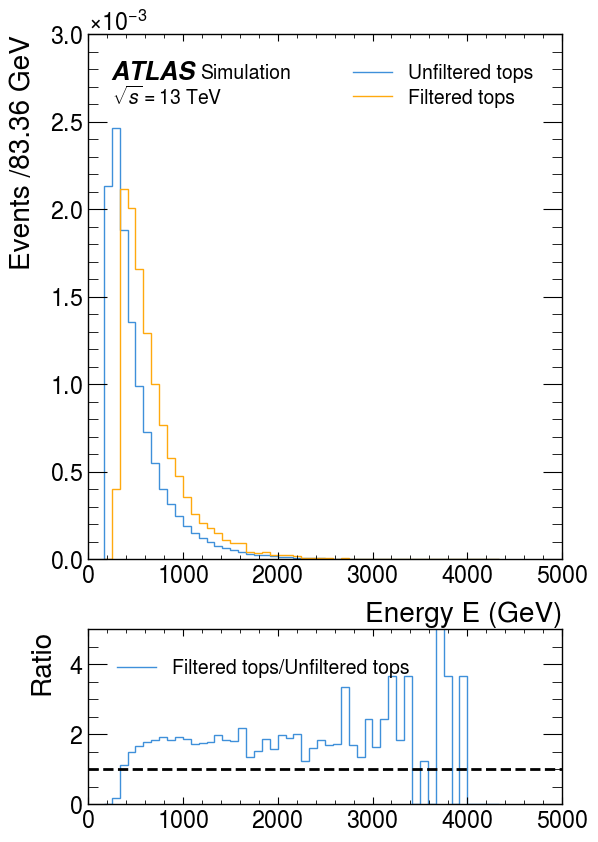

In [67]:
split_top_e = top_e.reshape(100000,1)
split_filtered_top_e = filtered_top_e.reshape(13634,1)

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6,10))
histogram([split_top_e, split_filtered_top_e], 50, ['Unfiltered tops','Filtered tops'], ax[0], density=True, ratio=True, ratio_axes=ax[1])
ax[0].set_xlabel(r"Energy E (GeV)")
plt.show()

### 2. Distribution of top pseudorapidity

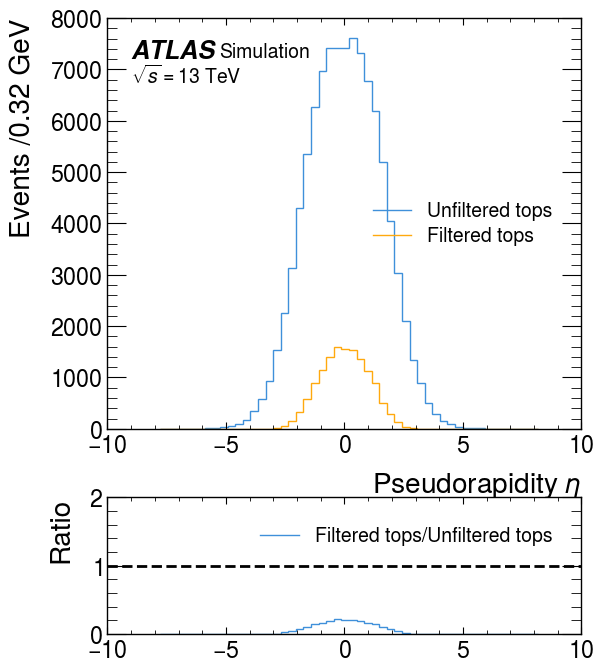

In [68]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6,8))
histogram([split_top_eta,split_filtered_top_eta], 50, ['Unfiltered tops', 'Filtered tops'], ax[0], ratio=True, ratio_axes=ax[1])
ax[0].set_xlabel(r"Pseudorapidity $\eta$")
plt.subplots_adjust(hspace=0.25)
plt.show()

### 3. Antitop pseudorapidity

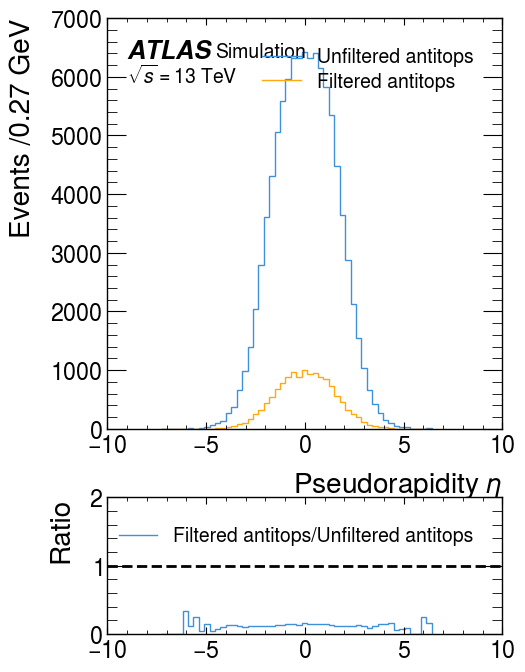

In [69]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(5,8))
histogram([split_antitop_eta,split_filtered_antitop_eta], 50, ['Unfiltered antitops', 'Filtered antitops'], ax[0], ratio=True, ratio_axes=ax[1])
ax[0].set_xlabel(r"Pseudorapidity $\eta$")
ax[0].legend(loc = 'upper right')
plt.subplots_adjust(hspace=0.25)
plt.show()

### 4. Combined $\Delta$ R of 4 tops

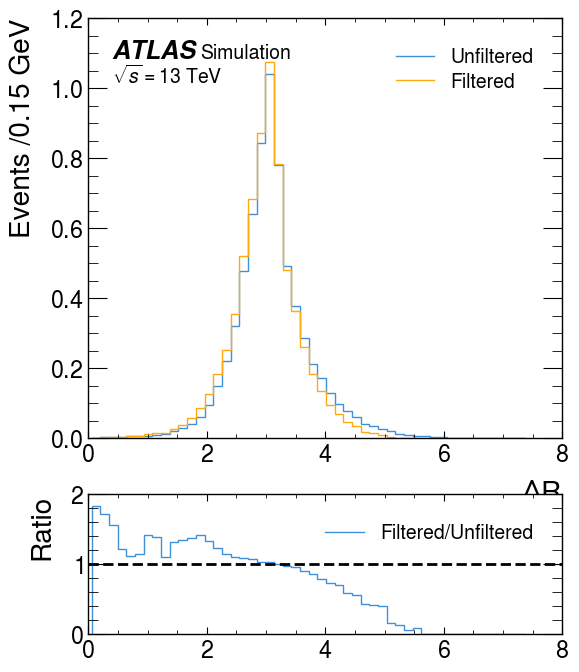

In [70]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([unfiltered_pt_deltaR_4t,pt_deltaR_4t], 50, ['Unfiltered', 'Filtered'], ax[0], ratio=True, density=True, ratio_axes=ax[1])
ax[0].set_xlabel('$\Delta$R')
plt.show()

## 2. Comparing 3tW and 3tj

### 1. Comparing $p_T$

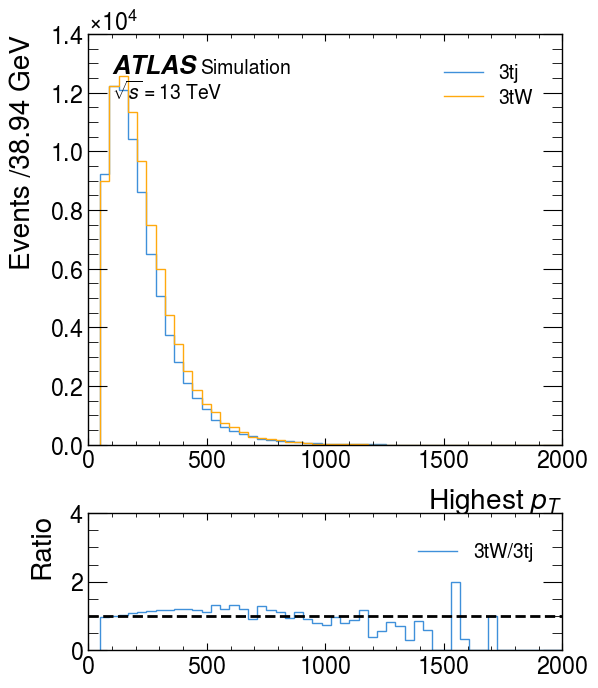

In [71]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([all_filtered_3tj.rho, all_filtered_3tW.rho], 50, ['3tj', '3tW'], ax[0], ratio=True, ratio_axes=ax[1])
ax[0].set_xlabel('Highest $p_T$')
plt.subplots_adjust(hspace=0.25)
plt.show()

### 2. Comparing $\Delta$ R

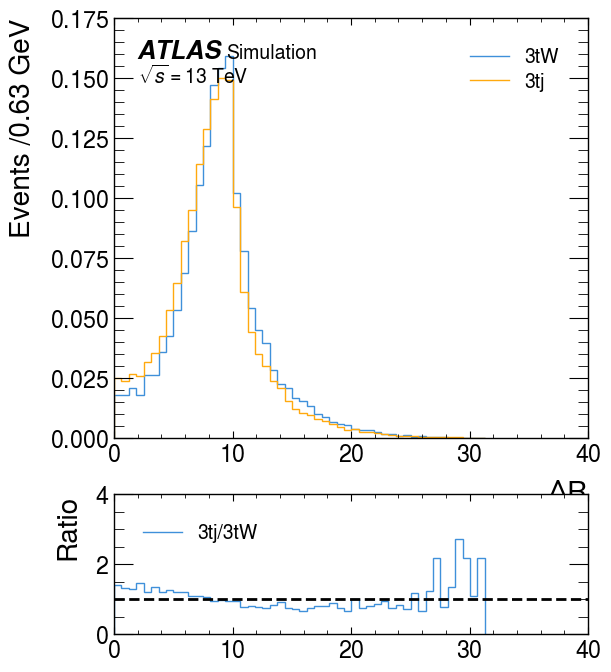

In [72]:
deltaR_3tW = highest_pt_3tW.deltaR2(second_highest_pt_3tW)
deltaR_3tj = highest_pt_3tj.deltaR2(second_highest_pt_3tj)

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([deltaR_3tW, deltaR_3tj], 50, ['3tW', '3tj'], ax[0], density=True, ratio=True, ratio_axes=ax[1])
ax[0].set_xlabel('$\Delta$R')
plt.show()

### 3. Comparing $\eta$

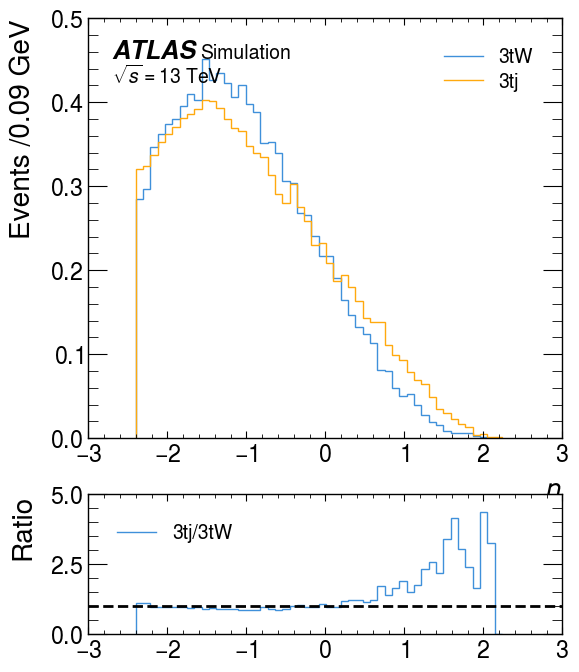

In [73]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([lowest_eta_3tW.eta, lowest_eta_3tj.eta], 50, ['3tW', '3tj'], ax[0], density=True, ratio=True, ratio_axes=ax[1])
ax[0].set_xlabel(r'$\eta$')
plt.show()

### 4. Comparing $\phi$

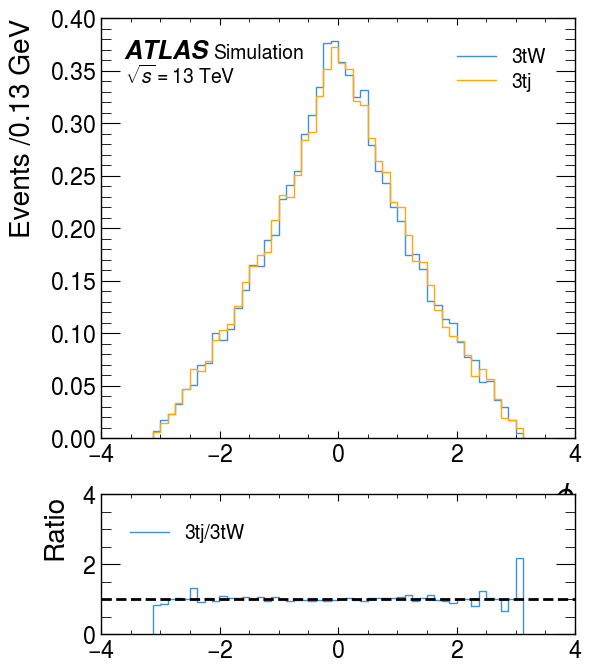

In [74]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([lowest_phi_3tW.phi, lowest_phi_3tj.phi], 50, ['3tW', '3tj'], ax[0], density=True, ratio=True, ratio_axes=ax[1])
ax[0].set_xlabel(r'$\phi$')
plt.show()

### 5. Comparing invariant mass

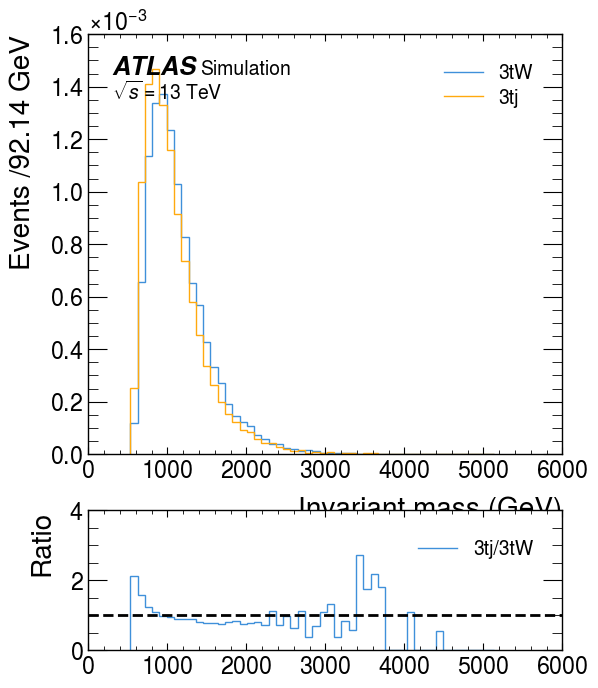

In [75]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([_3tWs.mass,_3tjs.mass], 50, ['3tW', '3tj'], ax[0], density=True, ratio=True, ratio_axes=ax[1])
ax[0].set_xlabel('Invariant mass (GeV)')
plt.show()

### 6. Comparing energy

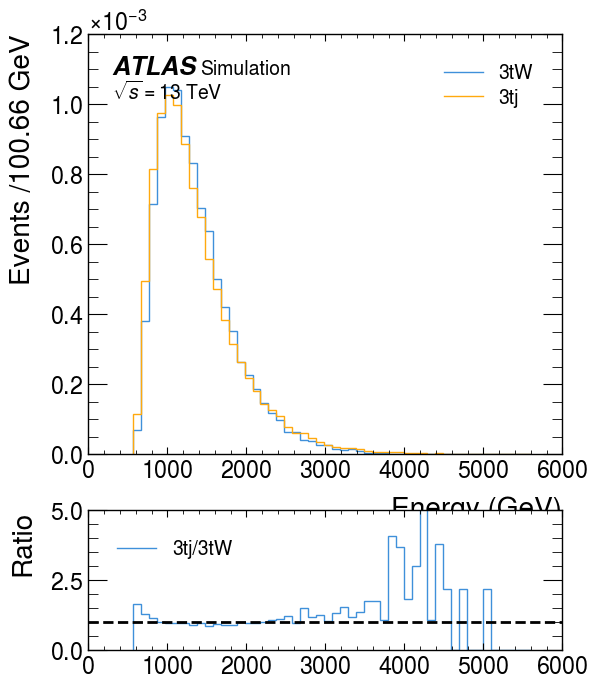

In [76]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([_3tWs.E, _3tjs.E], 50, ['3tW', '3tj'], ax[0], density=True, ratio=True, ratio_axes=ax[1])
ax[0].set_xlabel('Energy (GeV)')
plt.show()

### 7. Comparing quarks with the highest energies

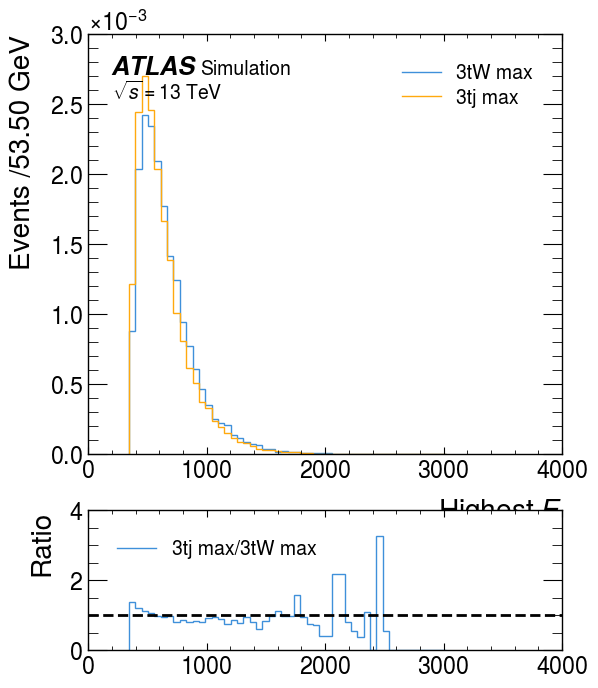

In [77]:

fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([(highest_E_3tW + second_highest_E_3tW).mass, (highest_E_3tj + second_highest_E_3tj).mass], 50, ['3tW max', '3tj max', '3tWs', '3tjs'], ax[0], density=True, ratio=True, ratio_axes=ax[1])
ax[0].set_xlabel(r'Highest $E$')
plt.show()

## 3. Comparing 3t and 4t

### 1. Comparing lowest and highest $p_T$

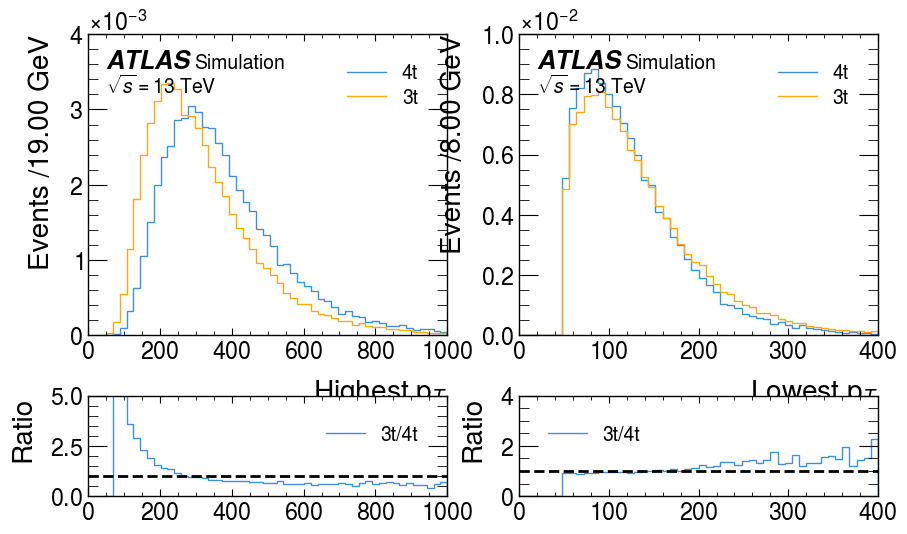

In [78]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_pt_4t.pt, highest_pt_3t.pt], 50, [r'4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(50,1000))
histogram([lowest_pt_4t.pt, lowest_pt_3t.pt], 50, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,400))
ax[0,0].set_xlabel(r'Highest p$_T$')
ax[0,1].set_xlabel(r'Lowest p$_T$')
plt.subplots_adjust(hspace=0.3)
plt.show()

c:\Users\matis\anaconda3\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


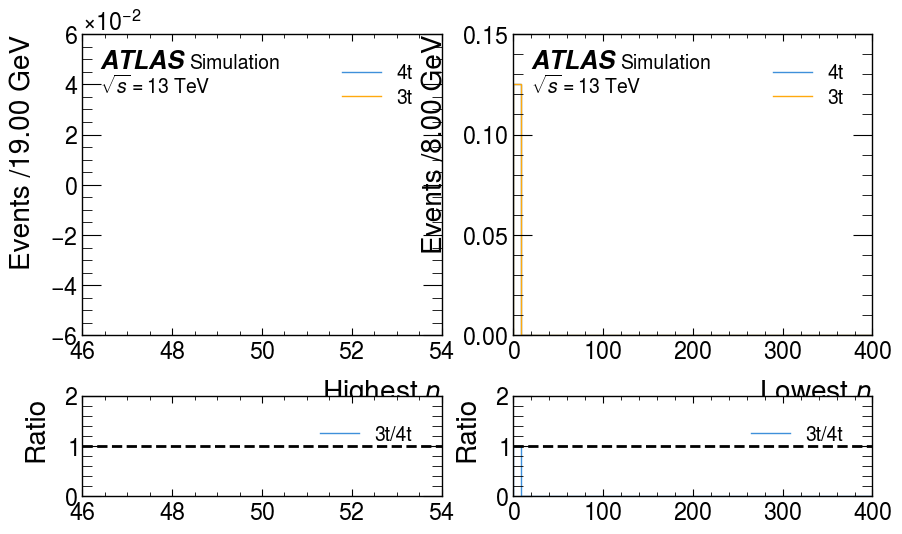

In [92]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_pt_4t.eta, highest_pt_3t.eta], 50, [r'4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(50,1000))
histogram([lowest_pt_4t.eta, lowest_pt_3t.eta], 50, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,400))
ax[0,0].set_xlabel(r'Highest $\eta$')
ax[0,1].set_xlabel(r'Lowest $\eta$')
plt.subplots_adjust(hspace=0.3)
plt.show()

### 2. Comparing lowest and highest $\eta$

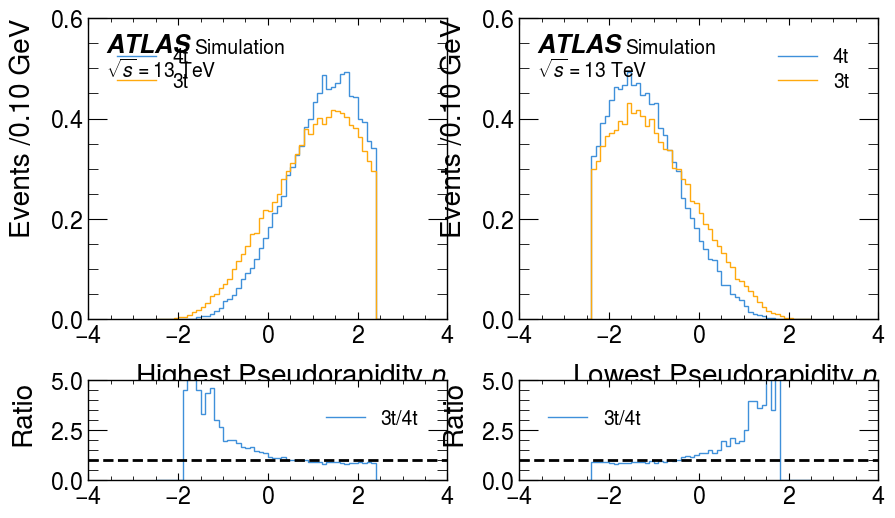

In [80]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_eta_4t.eta, highest_eta_3t.eta], 50, [r'4t', r'3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(-2.5,2.5))
ax[0,0].set_xlabel(r'Highest Pseudorapidity $\eta$')
histogram([lowest_eta_4t.eta, lowest_eta_3t.eta], 50, [r'4t', r'3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(-2.5,2.5))
ax[0,1].set_xlabel(r'Lowest Pseudorapidity $\eta$')
plt.subplots_adjust(hspace=0.3)
plt.show()

### 3. Comparing lowest and highest $|\eta|$

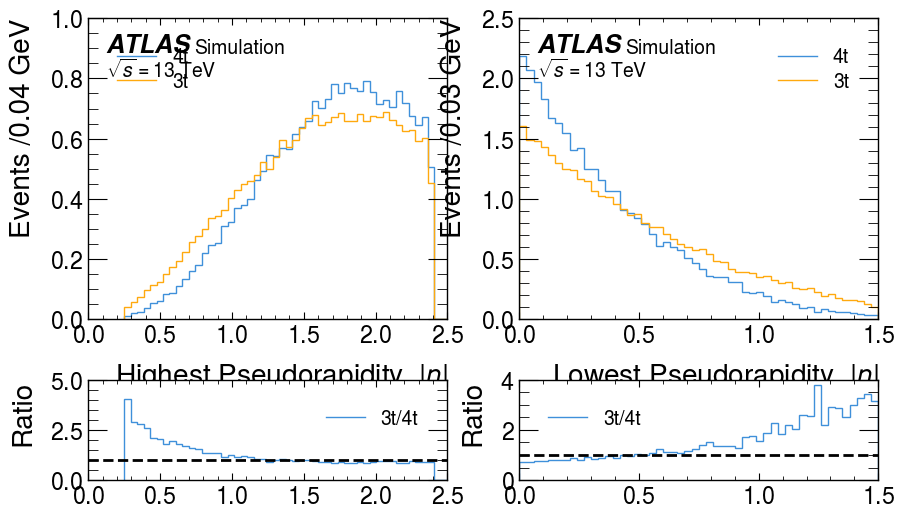

In [81]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([np.abs(abs_highest_eta_4t.eta), np.abs(abs_highest_eta_3t.eta)], 50, [r'4t', r'3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0.25,2.5))
ax[0,0].set_xlabel(r'Highest Pseudorapidity, $|\eta|$')
histogram([np.abs(abs_lowest_eta_4t.eta), np.abs(abs_lowest_eta_3t.eta)], 50, [r'4t', r'3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,1.5))
ax[0,1].set_xlabel(r'Lowest Pseudorapidity, $|\eta|$')
plt.subplots_adjust(hspace=0.3)
plt.show()

### 4. Comparing lowest  and highest $\phi$

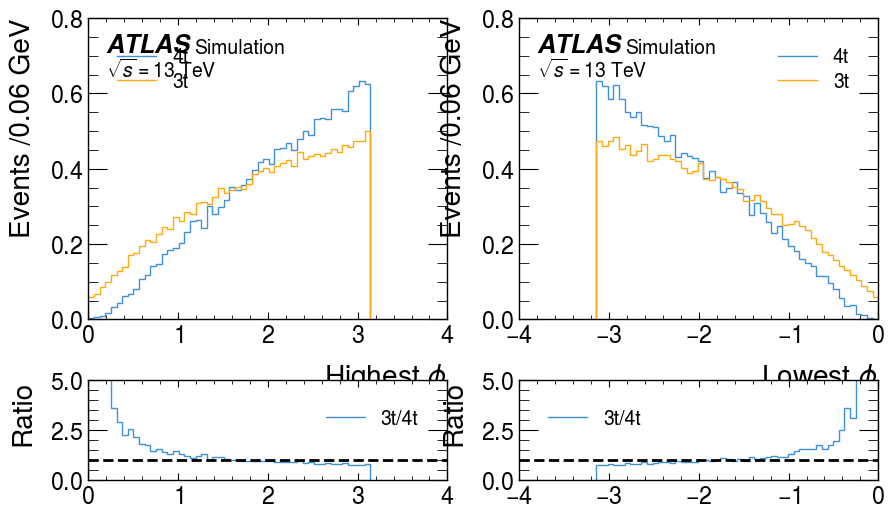

In [82]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_phi_4t.phi, highest_phi_3t.phi], 50, ['4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,np.pi))
ax[0,0].set_xlabel(r'Highest $\phi$')
histogram([lowest_phi_4t.phi, lowest_phi_3t.phi], 50, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(-np.pi,0))
ax[0,1].set_xlabel(r'Lowest $\phi$')
plt.subplots_adjust(hspace=0.3)
plt.show()

### 5. Comparing lowest and highest $|\phi|$

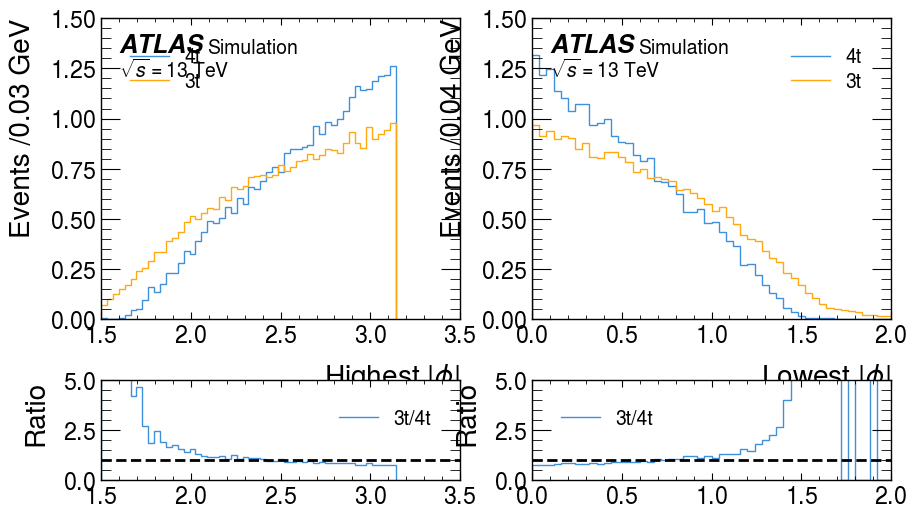

In [83]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([np.abs(abs_highest_phi_4t.phi), np.abs(abs_highest_phi_3t.phi)], 50, ['4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(1.5,np.pi))
ax[0,0].set_xlabel(r'Highest $|\phi|$')
histogram([np.abs(abs_lowest_phi_4t.phi), np.abs(abs_lowest_phi_3t.phi)], 50, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,2))
ax[0,1].set_xlabel(r'Lowest $|\phi|$')
plt.subplots_adjust(hspace=0.3)
plt.show()

### 6. Comparing highest and lowest energy

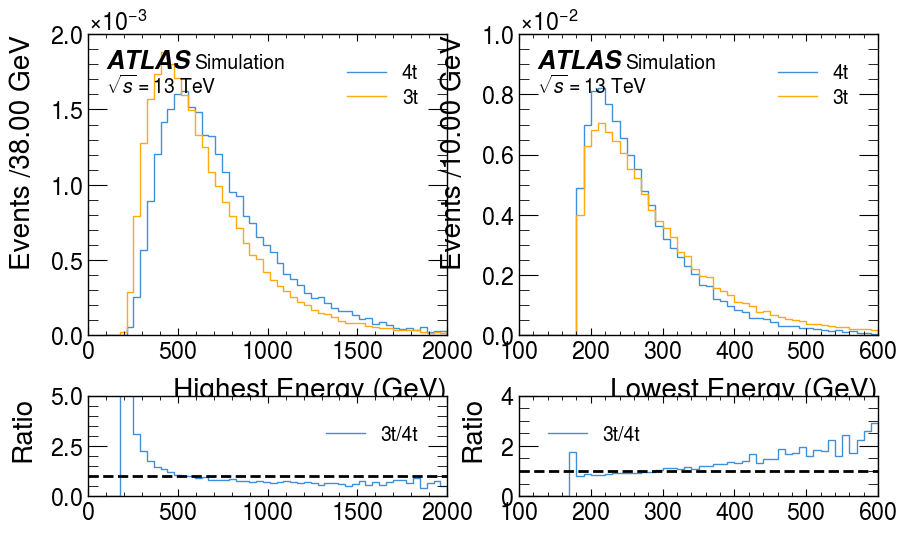

In [84]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,6))
histogram([highest_e_4t.E, highest_e_3t.E], 50, ['4t', '3t'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(100,2000))
ax[0,0].set_xlabel(r'Highest Energy (GeV)')
histogram([lowest_e_4t.E, lowest_e_3t.E], 50, ['4t', '3t'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(100,600))
ax[0,1].set_xlabel(r'Lowest Energy (GeV)')
plt.subplots_adjust(hspace=0.3)
plt.show()

### 7. Comparing $\Delta$ R between quarks with the highest $p_T$ and energy   

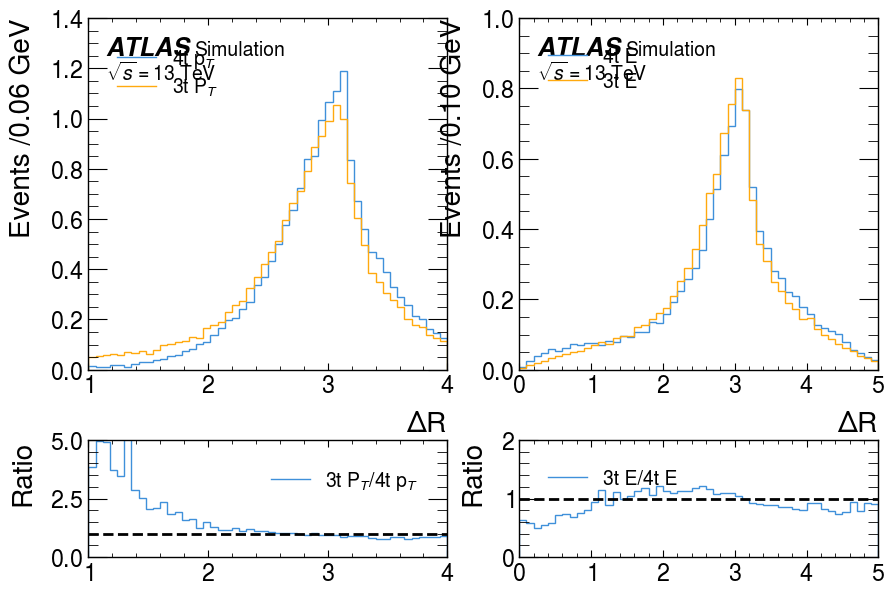

In [85]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([pt_deltaR_4t, pt_deltaR_3t], 50, [r'4t p$_T$', r'3t P$_T$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(1,4))
ax[0,0].set_xlabel(r'$\Delta$R')
histogram([e_deltaR_4t, e_deltaR_3t], 50, [r'4t E', r'3t E'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,5))
ax[0,1].set_xlabel(r'$\Delta$R')
plt.show()

### 8. Comparing $\Delta$ R between quarks with the highest $\phi$ and $\eta$   

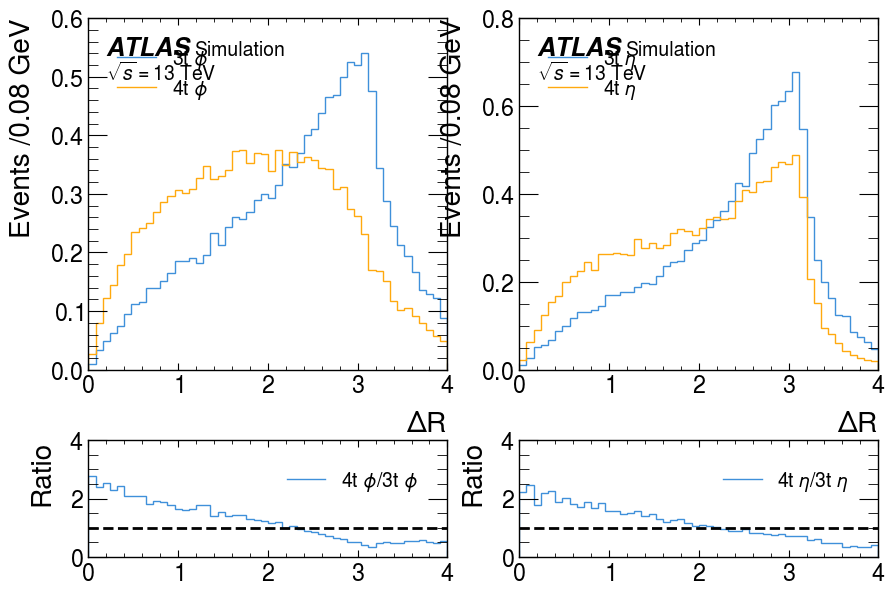

In [86]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([phi_deltaR_3t, phi_deltaR_4t], 50, [r'3t $\phi$', r'4t $\phi$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,4))
ax[0,0].set_xlabel(r'$\Delta$R')
histogram([eta_deltaR_3t, eta_deltaR_4t], 50, [r'3t $\eta$', r'4t $\eta$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,4))
ax[0,1].set_xlabel(r'$\Delta$R')
plt.show()

### 9. Comparing $\Delta$ R between quarks with the highest $|\phi|$ and $|\eta|$   

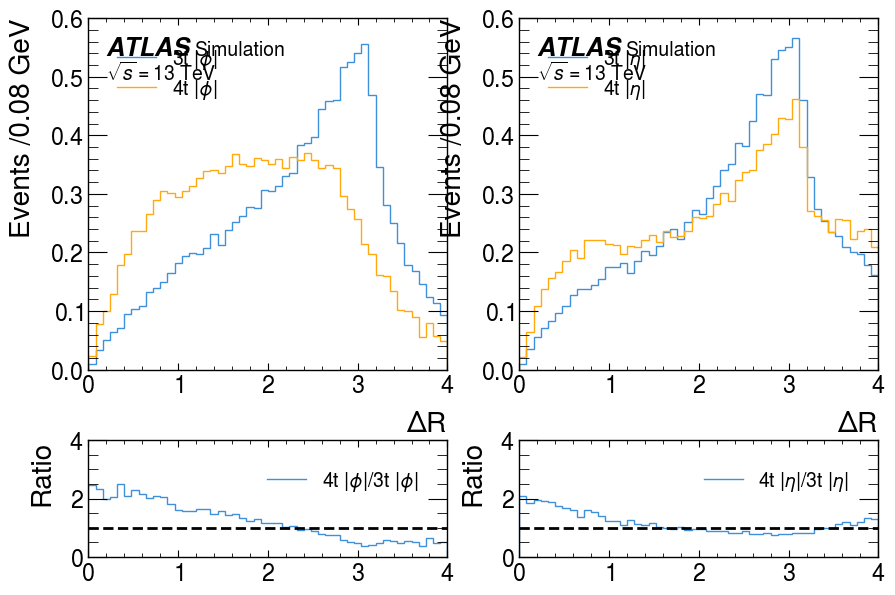

In [87]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([abs_phi_deltaR_3t, abs_phi_deltaR_4t], 50, [r'3t $|\phi|$', r'4t $|\phi|$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,4))
ax[0,0].set_xlabel(r'$\Delta$R')
histogram([abs_eta_deltaR_3t, abs_eta_deltaR_4t], 50, [r'3t $|\eta|$', r'4t $|\eta|$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,4))
ax[0,1].set_xlabel(r'$\Delta$R')
plt.show()

### 10. Comparing $\Delta$ $\phi$ and $\Delta$ $\eta$ between the particles in the highest $\Delta$ R   

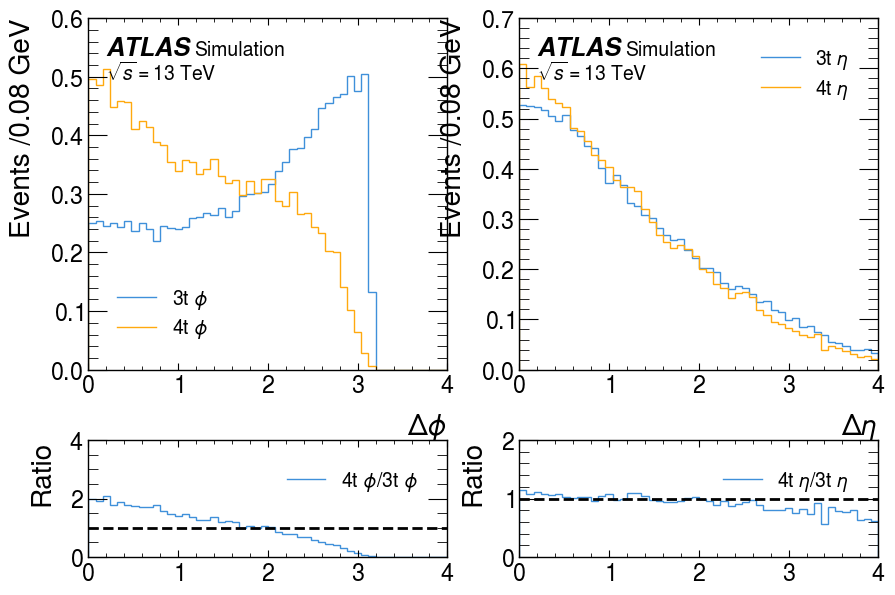

In [88]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([high_delta_phi_3t, high_delta_phi_4t], 50, [r'3t $\phi$', r'4t $\phi$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0], set_range=(0,4))
ax[0,0].set_xlabel(r'$\Delta\phi$')
histogram([high_delta_eta_3t, high_delta_eta_4t], 50, [r'3t $\eta$', r'4t $\eta$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1], set_range=(0,4))
ax[0,1].set_xlabel(r'$\Delta\eta$')
plt.show()

### 11. Comparing $\Delta$ $\phi$ and $\Delta$ $\eta$ between the particles in the lowest $\Delta$ R   

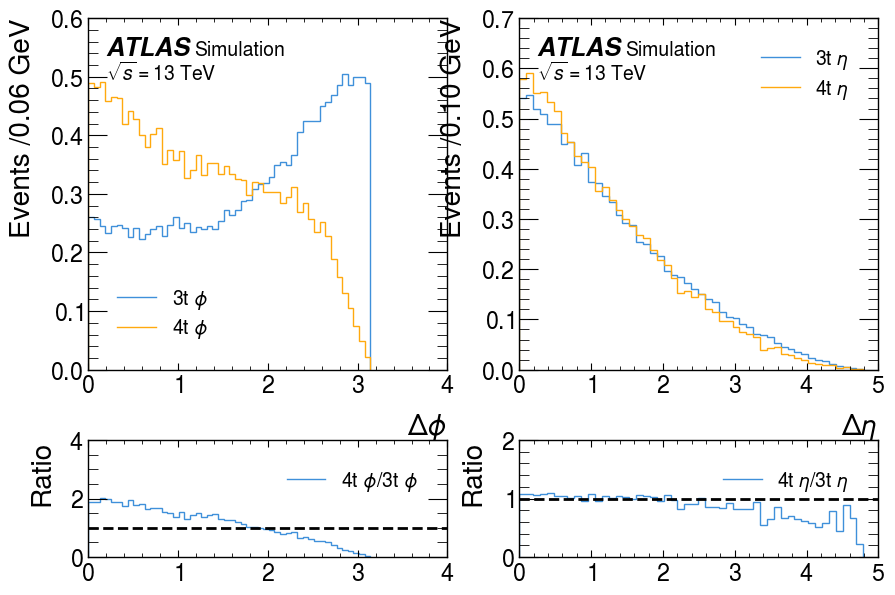

In [89]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, gridspec_kw={'height_ratios': [3, 1]},figsize = (10,7))
plt.subplots_adjust(hspace=0.3)
histogram([low_delta_phi_3t, low_delta_phi_4t], 50, [r'3t $\phi$', r'4t $\phi$'], ax[0,0],density=True, ratio=True, ratio_axes=ax[1,0])
ax[0,0].set_xlabel(r'$\Delta\phi$')
histogram([low_delta_eta_3t, low_delta_eta_4t], 50, [r'3t $\eta$', r'4t $\eta$'], ax[0,1],density=True, ratio=True, ratio_axes=ax[1,1])
ax[0,1].set_xlabel(r'$\Delta\eta$')
plt.show()

### 12. Comparing the lowest $p_T$ 

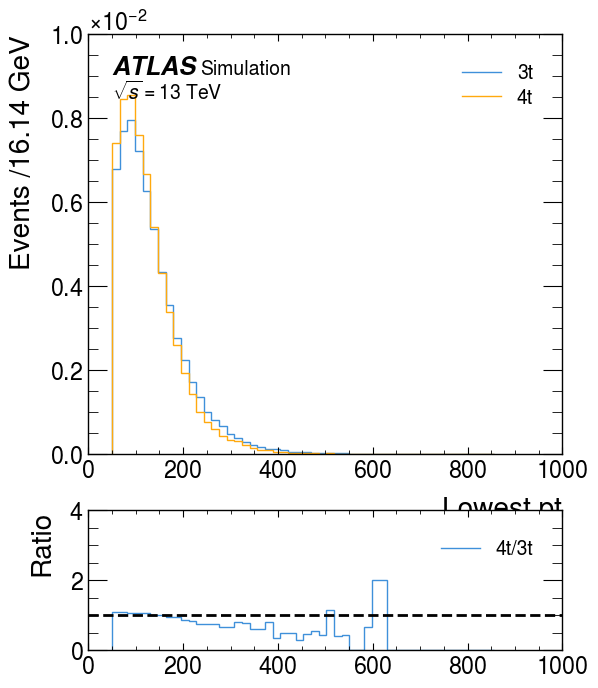

In [90]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([lowest_pt_3t.rho, lowest_pt_4t.rho], 50, ['3t', '4t'], ax[0],density=True, ratio=True, ratio_axes=ax[1])
ax[0].set_xlabel('Lowest pt')
plt.show()

### 13. Comparing $\eta$

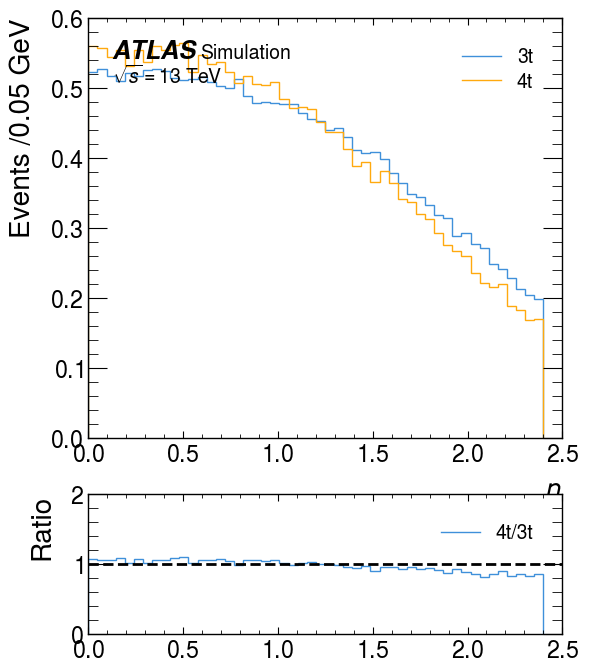

In [91]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, gridspec_kw={'height_ratios': [3, 1]},figsize = (6,8))
histogram([np.abs(transposed_3t.eta), np.abs(transposed_4t.eta)], 50, ['3t', '4t'], ax[0],density=True, ratio=True, ratio_axes=ax[1])
ax[0].set_xlabel('$\eta$')
plt.show()